In [3]:
import os
import time
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.metrics import roc_auc_score

# Part 2: Predict if clients would purchace products

### Task Description:
The objective is to predict whether a user will make a purchase in the upcoming month based on historical data. The dataset comprises three types of information:

- Transaction activity: Details about past transactions including amounts, types, and dates.
- Dialog embeddings: Embeddings extracted from customer interactions, capturing semantic information from dialogues.
- Geo-activity: Location-based data representing clients' geographic activity patterns.



### Mathematical Problem:


Let the dataset be defined as:
$$
D = \{ (x_i, y_i) \}_{i=1}^N,
$$
where for each user $i$:
- $(x_i \in \mathbb{R}^d)$ is a feature vector that combines the information from transactions, dialogs, and geo-activity.
- $(y_i \in \{0, 1\})$ is the binary label, where $(y_i = 1)$ indicates that the user made a purchase of any on 4 products in the next month, and $(y_i = 0)$ otherwise.

Our objective is to learn a function:
$$
f: \mathbb{R}^d \rightarrow [0, 1],
$$
parameterized by $(W)$, that estimates the probability of a purchase:
$$
P(y_i = 1 \mid x_i) \approx f(x_i; W).
$$


The model parameters $W$ are learned by minimizing the binary cross-entropy loss:
$$
L(\theta) = -\frac{1}{N} \sum_{i=1}^N \left[ y_i \log f(x_i; W) + (1 - y_i) \log \left( 1 - f(x_i; W) \right) \right].
$$

Thus, the optimization problem is the following:
$$
W^* = \arg\min_{W} L(W).
$$



### Other Potential Prediction Tasks:

1. **Predicting each purchase separately.**  
   Instead of grouping all four products together, we could build separate models for each one. 

2. **Customer churn prediction.**  
   By customer churn, we mean scenarios such as:
    - A significant decrease in the number of transactions,
    - No transactions at all in the following month,
    - An increase in the "diff_trans_date" metric, which indicates a weakening interest.

   In plain terms, we can try to predict the probability that a user will show signs of churning based on these factors. 



### The second task: Predicting each purchase separately


This task is the same as the first one, except now we need to build four separate functions — one for each product. In other words, for each product $j$ (with $j = 1, 2, 3, 4$), we want to find a function:
$$
f_j: \mathbb{R}^d \to [0, 1],
$$
that predicts the probability:
$$
P(y_{ij} = 1 \mid \mathbf{x}_i) \approx f_j(\mathbf{x}_i),
$$
where $y_{ij}$ is the binary label indicating whether user $i$ purchased product $j$ in the next month.

So, we just have four binary prediction tasks, one for each product, instead of a single aggregated task.


### Limitations and Assumptions

Due to limited time and the resources of my computer, I've made the following assumptions:

- **Reduced Dataset:** All experiments are conducted on a smaller dataset called `MDB_mini`, which is 10% of the main dataset.
- **Exclusion of Geo Data:** The experiments do not include any geolocation data.
- **Naive Time Window Assumption:** It is assumed that only data from the previous month influences the purchase decision, and all features are constructed using only this data. Due to time constraints, I didn't have the opportunity to experiment extensively with additional feature engineering.

________

### Feature Engineering

#### 1. Load data

In [54]:
! ls MBD_mini/client_split/

'fold=0'  'fold=1'  'fold=2'  'fold=3'	'fold=4'   _SUCCESS


In [12]:
def load_data(folder_path, save_fold=False):
    N_FOLDS = 5
    storage = []
    for fold in range(N_FOLDS):
        sub_folder_path = os.path.join(folder_path, f'fold={fold}')
        for file_name in tqdm(os.listdir(sub_folder_path)):
            file_path = os.path.join(sub_folder_path, file_name)
            if file_name.endswith('.c000.snappy.parquet'):
                df_ = pd.read_parquet(file_path)
                if save_fold:
                    df_['fold'] = [fold for _ in df_.index]
                storage.append(df_)
    
    return pd.concat(storage, ignore_index=True)

In [4]:
### Load data
df_trx = load_data('MBD_mini/detail/trx')

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

  0%|          | 0/80 [00:00<?, ?it/s]

In [21]:
df_dialog = load_data('MBD_mini/detail/dialog')

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

In [ ]:
df_targets = load_data('MBD_mini/targets', save_fold=True)

#### 2. Naive assumptions

Let's assume, that only data from the previous month influences the purchase decision

In [9]:
df_targets.mon.min(), df_targets.mon.max()

In [10]:
df_trx.event_time.min(), df_trx.event_time.max()

(Timestamp('2020-12-31 21:00:02.169545'),
 Timestamp('2022-12-31 20:59:58.460193'))

In [6]:
df_trx = df_trx[df_trx.event_time >= '2022-01-01 00:00:00']
df_trx = df_trx.reset_index(drop=True)
df_trx.shape

(19376661, 14)

In [7]:
df_trx.head(3)

,client_id,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32
0,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-03-24 03:29:41.340756,386029.250000,1,12,11.0,35.0,804.0,780.0,14702.0,9477.0,7.0,1846.0,60.0
1,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-11-17 10:59:23.860466,12148.564453,1,12,11.0,35.0,804.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
2,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-09-26 07:03:10.836433,34440.183594,1,12,11.0,35.0,804.0,780.0,21619.0,9477.0,7.0,1846.0,60.0


In [15]:
df_trx.describe(include='all')

,client_id,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32
count,19376661,19376661,1.937666e+07,1.937666e+07,1.937666e+07,1.937663e+07,1.926993e+07,1.926993e+07,1.925457e+07,1.925457e+07,1.935820e+07,1.935820e+07,1.933891e+07,1.933891e+07
unique,97880,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,9162f460905b0c6838d781fb85f47616ae17e06ea3af99...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,434336,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,2022-07-08 02:50:21.443281920,7.805149e+05,2.241762e+01,2.735363e+01,1.099796e+01,3.689248e+01,2.374052e+02,7.385564e+02,2.077598e+04,2.437348e+04,3.450504e+01,1.190081e+03,4.004008e+01
min,NaN,2022-01-01 00:00:10.252576,3.021821e-06,1.000000e+00,1.000000e+00,1.000000e+00,4.000000e+00,1.000000e+00,5.000000e+00,2.120000e+02,7.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
25%,NaN,2022-04-08 06:05:36.417217024,2.534839e+03,1.000000e+00,1.200000e+01,1.100000e+01,2.200000e+01,4.700000e+01,3.060000e+02,1.606700e+04,1.330600e+04,8.000000e+00,5.460000e+02,1.900000e+01
50%,NaN,2022-07-10 07:03:59.533435904,1.856530e+04,1.100000e+01,2.200000e+01,1.100000e+01,2.200000e+01,4.700000e+01,7.800000e+02,2.161900e+04,2.420600e+04,2.500000e+01,1.120000e+03,3.600000e+01
75%,NaN,2022-10-08 03:44:12.058232064,9.765530e+04,4.600000e+01,4.000000e+01,1.100000e+01,2.200000e+01,4.650000e+02,7.930000e+02,2.676600e+04,3.636100e+04,5.600000e+01,1.846000e+03,6.000000e+01
max,NaN,2022-12-31 20:59:58.460193,1.249049e+11,5.600000e+01,6.200000e+01,1.700000e+01,1.860000e+02,1.143000e+03,1.713000e+03,3.305500e+04,4.892300e+04,8.800000e+01,2.506000e+03,8.900000e+01


#### 3. Transactions features

In [8]:
### Step 1: Process transaction
### Step 1.1: Sender / Contractor features, types

cols_src_list = [
    'src_type11', 'src_type12',
    'src_type21', 'src_type22',
    'src_type31', 'src_type32'
]
cols_dst_list = [
    'dst_type11', 'dst_type12',
]
cols_all = cols_src_list + cols_dst_list

### Fill nan 
df_trx[cols_all] = df_trx[cols_all].fillna(-1)

### Save matches:
for col_src in cols_src_list:
    for col_dst in cols_dst_list:
        df_trx['match_{}_{}'.format(col_src, col_dst)] = ((df_trx[col_src] == df_trx[col_dst]) * (df_trx[col_src] != -1)).astype(int)

### For src_types: unite rare types to one type
count_values = 0
for col in cols_all:
    print(col)
    threshold = 0.005 #if col in ['src_type21', 'src_type22', 'src_type31', 'src_type32'] else 0.001
    freq = df_trx[col].value_counts(normalize=True)
    valid_categories = freq[freq > threshold].index
    count_values += valid_categories.shape[0]
    
    print('valid_categories:', valid_categories)
    df_trx.loc[~df_trx[col].isin(valid_categories), col] = -1

print('\nNumber of unique values for one-hot encoding:', count_values)

#### One-hot-encoding
for col in cols_all:
    df_trx[col] = df_trx[col].astype('category')

df_trx= pd.get_dummies(
    df_trx, 
    columns=cols_all, 
    prefix=cols_all, 
)
print('New size:', df_trx.shape)


src_type11
valid_categories: Index([22.0, 35.0, 134.0, 175.0, 141.0, 102.0, 105.0, 4.0, -1.0], dtype='float64', name='src_type11')
src_type12
valid_categories: Index([  47.0,  465.0,  804.0,  689.0, 1009.0,   78.0,  501.0,  806.0,  856.0,
        969.0,  839.0,   15.0,  958.0,  709.0,  265.0,   -1.0,  530.0],
      dtype='float64', name='src_type12')
src_type21
valid_categories: Index([24206.0, 15343.0, 22508.0, 13436.0, 45253.0, 40357.0,  7814.0, 25317.0,
       33016.0,  5630.0, 19695.0, 13306.0],
      dtype='float64', name='src_type21')
src_type22
valid_categories: Index([ 8.0, 23.0,  4.0, 20.0, 46.0, 56.0, 87.0, 86.0, 38.0, 51.0, 21.0, 34.0,
       13.0, 65.0, 25.0, 84.0, 15.0, 78.0, 54.0,  9.0, 61.0, 16.0, 42.0, 62.0,
       11.0, 29.0, 18.0, 30.0,  5.0, 50.0,  1.0, 31.0, 12.0, 74.0, 45.0, 37.0,
       66.0, 14.0, 52.0, 83.0, 28.0, 41.0, 10.0, 82.0, 76.0,  2.0, 47.0, 88.0,
       71.0, 39.0, 73.0, 60.0, 79.0, 69.0, 64.0],
      dtype='float64', name='src_type22')
src_type31
valid

In [10]:
### Step 1.2: Transaction types

#### Add additional info about rare transaction type and subtype
freq_type = df_trx['event_type'].value_counts(normalize=True)
freq_subtype = df_trx['event_subtype'].value_counts(normalize=True)

threshold = 0.001

rare_types = freq_type[freq_type < threshold].index
rare_subtypes = freq_subtype[freq_subtype < threshold].index

df_trx['is_rare_event_type'] = df_trx['event_type'].isin(rare_types).astype(int)
df_trx['is_rare_event_subtype'] = df_trx['event_subtype'].isin(rare_subtypes).astype(int)

print('Rare flags are created!')

#### One-hot-encoding
df_trx['event_type'] = df_trx['event_type'].astype('category')
df_trx['event_subtype'] = df_trx['event_subtype'].astype('category')

df_trx= pd.get_dummies(
    df_trx, 
    columns=['event_type', 'event_subtype'], 
    prefix=['event_type', 'event_subtype'], 
)
print('New size:', df_trx.shape)

Rare flags are created!
New size: (19376661, 322)


In [11]:
### Step 1.3: Currency & amount

df_trx['currency'] = df_trx['currency'].fillna(-1)

#### Find enormous big transactions, taking into account the currency type
df_trx['threshold_95'] = df_trx.groupby('currency')['amount'].transform(lambda x: x.quantile(0.95))
df_trx['is_huge_transfer'] = (df_trx['amount'] > df_trx['threshold_95']).astype(int)
df_trx.drop('threshold_95', axis=1, inplace=True)

outlier_rate = df_trx.groupby('currency')['is_huge_transfer'].mean().reset_index()
print(outlier_rate)

#### Create amount columns for each currency
currency_dummies = pd.get_dummies(df_trx['currency'], prefix='currency')
amount_columns = pd.get_dummies(df_trx['currency'], prefix='amount').multiply(df_trx['amount'], axis=0)
df_trx = pd.concat([df_trx, currency_dummies, amount_columns], axis=1)

print('New size:', df_trx.shape)

    currency  is_huge_transfer
0       -1.0          0.058824
1        1.0          0.051724
2        3.0          0.050165
3        4.0          0.050308
4        5.0          0.200000
5        6.0          0.052632
6        8.0          0.052632
7       10.0          0.053691
8       11.0          0.050000
9       15.0          0.050000
10      16.0          0.250000
11      17.0          0.050314
New size: (19376661, 347)


In [12]:
### Step 1.4: Time 

#### For aggregation
df_trx['event_time'] = pd.to_datetime(df_trx['event_time'])
df_trx['mon'] = df_trx['event_time'].dt.to_period('M').dt.to_timestamp()
df_trx['month_end'] = df_trx['mon'] + pd.offsets.MonthEnd(0)

#### Period of the day
df_trx['hour'] = df_trx['event_time'].dt.hour
df_trx['is_morning'] = ((df_trx['hour'] >= 6) & (df_trx['hour'] < 12)).astype(int)
df_trx['is_afternoon'] = ((df_trx['hour'] >= 12) & (df_trx['hour'] < 18)).astype(int)
df_trx['is_evening'] = ((df_trx['hour'] >= 18) & (df_trx['hour'] < 24)).astype(int)
df_trx['is_night'] = ((df_trx['hour'] >= 0) & (df_trx['hour'] < 6)).astype(int)

In [10]:
df_trx.shape

(19376661, 354)

In [ ]:
### Step 2: Create month aggregates

#### Get columns list
binary_cols = [
    'is_rare_event_type', 'is_rare_event_subtype', 'is_huge_transfer'
]
amount_cols, currency_cols = [], []
for col in df_trx.columns:
    if col.startswith('match_src') or col.startswith('src_type') or col.startswith('dst_type') \
        or col.startswith('event_type') or col.startswith('event_subtype'):
        binary_cols.append(col)
    elif col.startswith('amount_'):
        amount_cols.append(col)
    elif col.startswith('currency_'):
        currency_cols.append(col)

### Cast types
df_trx['client_id'] = df_trx['client_id'].astype('category')
df_trx['mon'] = df_trx['mon'].astype('category')

for col in binary_cols:
    df_trx[col] = df_trx[col].astype('bool') 


In [14]:
df_trx.head(2)

,client_id,event_time,amount,currency,match_src_type11_dst_type11,match_src_type11_dst_type12,match_src_type12_dst_type11,match_src_type12_dst_type12,match_src_type21_dst_type11,match_src_type21_dst_type12,...,amount_15.0,amount_16.0,amount_17.0,mon,month_end,hour,is_morning,is_afternoon,is_evening,is_night
0,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-03-24 03:29:41.340756,3.860292e+05,11.0,False,False,False,False,False,False,...,0.0,0.0,0.0,2022-03-01,2022-03-31,3,0,0,0,1
1,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-11-17 10:59:23.860466,1.214856e+04,11.0,False,False,False,False,False,False,...,0.0,0.0,0.0,2022-11-01,2022-11-30,10,1,0,0,0
2,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-09-26 07:03:10.836433,3.444018e+04,11.0,False,False,False,False,False,False,...,0.0,0.0,0.0,2022-09-01,2022-09-30,7,1,0,0,0
3,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-09-21 03:59:32.183742,9.544843e+03,11.0,False,False,False,False,False,False,...,0.0,0.0,0.0,2022-09-01,2022-09-30,3,0,0,0,1
4,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-03-15 09:03:37.963142,8.574763e+03,11.0,False,False,False,False,False,False,...,0.0,0.0,0.0,2022-03-01,2022-03-31,9,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19376656,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-08-10 13:14:11.427807,1.149164e+06,11.0,False,False,False,False,False,False,...,0.0,0.0,0.0,2022-08-01,2022-08-31,13,0,1,0,0
19376657,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-08-30 03:02:21.644615,4.215694e+03,11.0,False,False,False,False,False,False,...,0.0,0.0,0.0,2022-08-01,2022-08-31,3,0,0,0,1
19376658,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-09-23 13:13:41.643101,2.814023e+04,11.0,False,False,False,False,False,False,...,0.0,0.0,0.0,2022-09-01,2022-09-30,13,0,1,0,0
19376659,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-12-21 09:37:36.837476,2.264204e+04,11.0,False,False,False,False,False,False,...,0.0,0.0,0.0,2022-12-01,2022-12-31,9,1,0,0,0


In [62]:

timeofday_cols = ['is_morning', 'is_afternoon', 'is_evening', 'is_night']

df_trx['trx_dummy'] = 1

agg_dict = {}

#### Sum of transactions
agg_dict['trx_dummy'] = 'sum'

#### Recency: 
agg_dict['event_time'] = 'max'
agg_dict['month_end'] = 'first'

#### Binary features
for col in binary_cols:
    agg_dict[col] = ['sum', 'mean']

#### Ammount for each currency
for col in amount_cols:
    agg_dict[col] = ['sum', 'mean', 'median', 'std']

#### Currency 
for col in currency_cols:
    agg_dict[col] = ['sum', 'mean']

#### Time of the day dependence
for col in timeofday_cols:
    agg_dict[col] = 'mean'

#### Group by 'client_id', 'mon'
print('Start aggregation:')
start = time.time()
df_agg = df_trx.groupby(['client_id', 'mon'],  observed=True).agg(agg_dict).reset_index()
end = time.time()
print('Time for aggregation: {:.2f} sec'.format(end - start))

df_agg.columns = ['_'.join(filter(None, map(str, col))).strip() for col in df_agg.columns.values]

#### Calc recency
df_agg['recency_days'] = (df_agg['month_end_first'] - df_agg['event_time_max']).dt.total_seconds() / (3600 * 24)

### In case there was just one trx for some (client_id, mon), we need to fill amount_std with 0
cols_std = [col for col in df_agg.columns if col.endswith('std') ]
df_agg[cols_std] = df_agg[cols_std].fillna(0.)

df_agg.head(3)

Start aggregation:
Time for aggregation: 213.95 sec


,client_id,mon,trx_dummy_sum,event_time_max,month_end_first,is_rare_event_type_sum,is_rare_event_type_mean,is_rare_event_subtype_sum,is_rare_event_subtype_mean,is_huge_transfer_sum,...,currency_15.0_mean,currency_16.0_sum,currency_16.0_mean,currency_17.0_sum,currency_17.0_mean,is_morning_mean,is_afternoon_mean,is_evening_mean,is_night_mean,recency_days
0,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-01-01,1,2022-01-15 10:11:22.554164,2022-01-31,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,1.000,0.000,0.000,0.000,15.575433
1,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-02-01,8,2022-02-27 22:45:57.499986,2022-02-28,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0.375,0.125,0.375,0.125,0.051418
2,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-03-01,8,2022-03-30 14:11:05.623517,2022-03-31,0,0.0,0,0.0,0,...,0.0,0,0.0,0,0.0,0.250,0.500,0.250,0.000,0.408963


In [91]:
### Check NaN
missing_counts = df_agg.isnull().sum()
for col, num in missing_counts.items():
    if num > 0:
        print(col, '\t', num)

In [92]:
### Save data
# ! mkdir MBD_mini/processed/
# df_agg.to_parquet("MBD_mini/processed/aggregated_trx.parquet", engine="pyarrow", compression="snappy")


#### 4. Dialogs features

In [22]:
df_dialog = load_data('MBD_mini/detail/dialog')

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

  0%|          | 0/83 [00:00<?, ?it/s]

In [23]:
df_dialog.head()

,client_id,event_time,embedding
0,0b24ce89a13ed016ed4d85dfcc35a3d23b4a6c55623f10...,2021-08-10 06:53:03.919580,"[0.5204847, -0.36356947, 0.5873236, -0.5300084..."
1,0b24ce89a13ed016ed4d85dfcc35a3d23b4a6c55623f10...,2022-07-02 08:42:37.747682,"[-0.12485484, 0.2615348, 0.18814501, 0.2496336..."
2,2bec204175e5c96d7cea3a026b8023a398fd35099397f3...,2022-08-22 09:03:04.159451,"[0.58111507, -0.33247072, 0.40077016, -0.42599..."
3,2bec204175e5c96d7cea3a026b8023a398fd35099397f3...,2022-10-10 07:23:37.933786,"[0.2050076, -0.061802614, 0.58545846, -0.50094..."
4,34c9b77b9cb90d872054ca09c33807f50bc4fe70131329...,2022-04-01 08:05:12.672084,"[0.21837933, -0.16559619, 0.40840292, -0.51622..."


In [26]:
### Preprocess 

df_dialog['event_time'] = pd.to_datetime(df_dialog['event_time'])
df_dialog['mon'] = df_dialog['event_time'].dt.to_period('M').dt.to_timestamp()
df_dialog['month_end'] = df_dialog['mon'] + pd.offsets.MonthEnd(0)


In [32]:
### Weeks

df_dialog['day'] = df_dialog['event_time'].dt.day
df_dialog['week_of_month'] = ((df_dialog['day'] - 1) // 7) + 1
df_dialog['max_week'] = df_dialog.groupby(['mon'])['week_of_month'].transform('max')
df_dialog['reversed_week'] = df_dialog['max_week'] - df_dialog['week_of_month'] + 1

for i in range(1, 6):
    df_dialog[f'is_week_{i}'] = (df_dialog['reversed_week'] == i).astype(int)


In [33]:
### Part of the day

df_dialog['hour'] = df_dialog['event_time'].dt.hour
df_dialog['is_night']   = ((df_dialog['hour'] >= 0)  & (df_dialog['hour'] < 6)).astype(int)
df_dialog['is_morning'] = ((df_dialog['hour'] >= 6)  & (df_dialog['hour'] < 12)).astype(int)
df_dialog['is_day']     = ((df_dialog['hour'] >= 12) & (df_dialog['hour'] < 18)).astype(int)
df_dialog['is_evening'] = ((df_dialog['hour'] >= 18) & (df_dialog['hour'] < 24)).astype(int)
timeofday_cols = ['is_night', 'is_morning', 'is_day', 'is_evening']


In [47]:
### Average embedding for the month
def average_embedding(emb_series):
    emb_array = np.stack(emb_series.values)
    return np.mean(emb_array, axis=0)

def std_embedding(emb_series):
    emb_array = np.stack(emb_series.values)
    return np.std(emb_array, axis=0)


In [ ]:
### Threshold for number of dialogs
group_sizes = df_dialog.groupby(['client_id', 'mon']).size()
global_threshold = np.percentile(group_sizes.values, 95)

In [49]:
### Group by 'client_id', 'mon'
start = time.time()
df_agg = df_dialog.groupby(['client_id', 'mon']).agg(
    dialog_count = ('client_id', 'count'),
    last_event   = ('event_time', 'max'),
    month_end    = ('month_end', 'first'),
    # Period of time:
    is_night     = ('is_night', 'mean'),
    is_morning   = ('is_morning', 'mean'),
    is_day       = ('is_day', 'mean'),
    is_evening   = ('is_evening', 'mean'),
    # Week of the month:
    calls_week_1 = ('is_week_1', 'sum'),
    calls_week_2 = ('is_week_2', 'sum'),
    calls_week_3 = ('is_week_3', 'sum'),
    calls_week_4 = ('is_week_4', 'sum'),
    calls_week_5 = ('is_week_5', 'sum'),
    # Average embedding:
    avg_embedding = ('embedding', average_embedding),
    std_embedding = ('embedding', std_embedding),
).reset_index()
end = time.time()
print('Time for aggregation: {:.2f} sec'.format(end - start))


Time for aggregation: 9.12 sec


In [50]:
### Recency
df_agg['recency_days'] = (df_agg['month_end'] - df_agg['last_event']).dt.total_seconds() / (3600 * 24)

### Very active user interection
df_agg['has_many_dialogs'] = (df_agg['dialog_count'] > global_threshold).astype(int)

### Embeddings: L2 norm & columns for each component
df_agg['avg_embedding_norm'] = df_agg['avg_embedding'].apply(lambda emb: np.linalg.norm(emb))

avg_emb_df = df_agg['avg_embedding'].apply(pd.Series).rename(columns=lambda x: f'avg_emb_{x}')
std_emb_df = df_agg['std_embedding'].apply(pd.Series).rename(columns=lambda x: f'std_emb_{x}')
df_agg = pd.concat([df_agg.drop(columns=['avg_embedding', 'std_embedding']), avg_emb_df, std_emb_df], axis=1)



In [54]:
# for col in df_agg.columns:
#     print(col)

In [55]:
df_agg.head(3)

,client_id,mon,dialog_count,last_event,month_end,is_night,is_morning,is_day,is_evening,calls_week_1,...,std_emb_758,std_emb_759,std_emb_760,std_emb_761,std_emb_762,std_emb_763,std_emb_764,std_emb_765,std_emb_766,std_emb_767
0,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-07-01,4,2022-07-16 09:55:15.545096,2022-07-31,0.0,0.5,0.5,0.0,0,...,0.265330,0.159299,0.168532,0.334994,0.118809,0.225296,0.123311,0.153072,0.139965,0.159585
1,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-08-01,2,2022-08-06 14:13:04.961468,2022-08-31,0.0,0.5,0.5,0.0,0,...,0.128919,0.033059,0.121121,0.049163,0.006823,0.127916,0.129668,0.056039,0.144474,0.044815
2,000032cc38caee45fe031778bcf6af05aa2aabe476acb8...,2022-12-01,1,2022-12-31 11:35:32.965246,2022-12-31,0.0,1.0,0.0,0.0,1,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [60]:
# df_agg.to_parquet("MBD_mini/processed/aggregated_dialog.parquet", engine="pyarrow", compression="snappy")



#### 5.  Merge Features 

In [4]:
print('Load data:')
start = time.time()
df_agg_dialog = pd.read_parquet("MBD_mini/processed/aggregated_dialog.parquet", engine="pyarrow")
print('\t- dialog: {} in {:.2f} sec'.format(df_agg_dialog.shape, time.time() - start))
start = time.time()
df_agg_trx = pd.read_parquet("MBD_mini/processed/aggregated_trx.parquet", engine="pyarrow")
print('\t- trx: {} in {:.2f} sec'.format(df_agg_trx.shape, time.time() - start))

Load data:
	- dialog: (133780, 1553) in 1.47 sec
	- trx: (925679, 720) in 1.22 sec


In [5]:
### Add prefix to column names

cols_dialog_rename_dict = {col: 'dialog_' + col for col in df_agg_dialog.columns if col not in ['client_id', 'mon']}
df_agg_dialog = df_agg_dialog.rename(columns=cols_dialog_rename_dict)
cols_trx_rename_dict = {col: 'trx_' + col for col in df_agg_trx.columns if col not in ['client_id', 'mon']}
df_agg_trx = df_agg_trx.rename(columns=cols_trx_rename_dict)

In [6]:
### Merge features 

start = time.time()
df_merged = pd.merge(df_agg_trx, df_agg_dialog, on=['client_id', 'mon'], how='left')
end = time.time()
print('Time for aggregation: {:.2f} sec'.format(end - start))

Time for aggregation: 4.48 sec


In [7]:
### Ignore some columns
cols_to_drop = [
    'dialog_last_event',
    'dialog_month_end',
    'trx_event_time_max',
    'trx_month_end_first',
]
df_merged = df_merged.drop(columns=cols_to_drop)

In [8]:
### Process
df_merged = df_merged.fillna(0)

### Shift month to merge with target
df_merged['mon'] = df_merged['mon'] + pd.offsets.MonthBegin(1) + pd.offsets.MonthEnd(1)
df_merged['mon'] = df_merged['mon'].dt.normalize()

In [9]:
missing_counts = df_merged.isnull().sum()
for col, num in missing_counts.items():
    if num > 0:
        print(col, '\t', num)
else:
    print('No NaN values')

No NaN values



#### 6.  Merge with Target 

In [13]:
df_targets = load_data('MBD_mini/targets', save_fold=True)

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

  0%|          | 0/87 [00:00<?, ?it/s]

In [14]:
df_targets['mon'] = pd.to_datetime(df_targets['mon'])

start = time.time()
df = pd.merge(df_merged, df_targets, on=['client_id', 'mon'], how='inner')
end = time.time()
print('Time for aggregation: {:.2f} sec'.format(end - start))

Time for aggregation: 8.41 sec


In [15]:
for target_id in range(1, 5):
    print(df_targets[f'target_{target_id}'].value_counts())

target_1
0    1197326
1       5362
Name: count, dtype: int64
target_2
0    1202111
1        577
Name: count, dtype: int64
target_3
0    1198158
1       4530
Name: count, dtype: int64
target_4
0    1199628
1       3060
Name: count, dtype: int64


**Note: There is a huge data imballance!**
We will implement downsampling & upsampling

In [ ]:
from sklearn.utils import resample

def combine_resample(df, target_column, random_state=42):
    print('Upsamle / Downsample:')
    
    ### Identify which class is a major/minor class
    class_counts = df[target_column].value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()
    
    df_majority = df[df[target_column] == majority_class]
    df_minority = df[df[target_column] == minority_class]
    print('\t- df_majority:', df_majority.shape[0])
    print('\t- df_minority:', df_minority.shape[0])

    ### Target number of samples
    # target_count = int((len(df_majority) + len(df_minority)) / 2) 
    target_count = len(df_minority) * 10

    ### Downsampling of majority_class
    df_majority_down = df_majority.sample(n=target_count, replace=False, random_state=random_state)
    print('\t- downsampling ready:', df_majority_down.shape[0])
    
    ### Upsampling of minority_class
    df_minority_up = df_minority.sample(n=target_count, replace=True, random_state=random_state)
    print('\t- upsampling ready:', df_minority_up.shape[0])
    
    ### Unite
    df_balanced = pd.concat([df_majority_down, df_minority_up])
    print('\t- concat done:', df_balanced.shape[0])
    
    ### Shuffle
    df_balanced = df_balanced.sample(frac=1, random_state=random_state).reset_index(drop=True)
    print('\t- shuffled:', df_balanced.shape[0])
    
    return df_balanced


### Task #2: Predicting probabilities of purchase for each product separately


In [19]:
cols_to_ignore = [
    'client_id', 'mon',
    'trans_count', 'diff_trans_date'
]

target_cols = ['target_1', 'target_2', 'target_3', 'target_4']
features = [col for col in df.columns if col not in cols_to_ignore + target_cols]


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, \
                f1_score, classification_report, confusion_matrix

params = {
    'objective': 'binary',                 # Задача бинарной классификации
    'metric': ['auc',  'binary_logloss'],   # Метрика для оценки – AUC
    'boosting_type': 'gbdt',               # Классический градиентный бустинг
    'num_leaves': 24,               # Максимальное число листьев (оптимальное значение зависит от данных)
    'max_depth': 5,                 # Ограничение глубины деревьев для предотвращения переобучения
    'learning_rate': 0.01,          # Скорость обучения
    'reg_alpha': 0.5,               # L1 регуляризация (Lasso) – штраф на абсолютные значения коэффициентов
    'reg_lambda': 0.5,              # L2 регуляризация (Ridge) – штраф на квадраты коэффициентов
    'min_split_gain': 0.01,         # Минимальное улучшение, необходимое для разделения узла
    'min_child_samples': 20,        # Минимальное число объектов в листе
    'subsample': 0.8,               # Доля выборки для каждой итерации (bagging)
    'colsample_bytree': 0.8,        # Доля признаков для каждого дерева
    'seed': 42,
    'is_unbalance': True,
}

results = {}

for fold in df_targets.fold.unique():
    results[fold] = {}
    print(f"Fold {fold}")
    print('-'*30)

    ### Get data 
    train_df = df[df['fold'] != fold]
    valid_df = df[df['fold'] == fold]
    
    print("\t- data was extracted")
    print('-'*30)
    
    for target in target_cols:
        results[fold][target] = {}
        print(f"\nTraining for target: {target}")

        ### Upsample / Downsample
        train_df_sampled = combine_resample(train_df, target, random_state=42)
        valid_df_sampled = combine_resample(valid_df, target, random_state=42)
        
        ### Dataset
        X_train = train_df_sampled[features]
        y_train = train_df_sampled[target]
        
        X_valid = valid_df_sampled[features]
        y_valid = valid_df_sampled[target]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
        print("\t- dataset is prepared")
        
        ### Train
        model = lgb.train(
            params,
            train_data,
            num_boost_round=1000,
            valid_sets=[train_data, valid_data],  
            callbacks=[
                lgb.log_evaluation(period=10),
                lgb.early_stopping(stopping_rounds=20),
            ]
        )
        print("\t- training is finished")
 
        ### Predict
        preds = model.predict(X_valid, num_iteration=model.best_iteration)
        binary_preds = (preds > 0.5).astype(int)
        print("\t- prediction is finished")
        
        ### Metrics
        results[fold][target] = {
            'model': model,
            'auc': roc_auc_score(y_valid, preds),
            'accuracy': accuracy_score(y_valid, binary_preds),
            'precision': precision_score(y_valid, binary_preds),
            'recall': recall_score(y_valid, binary_preds),
            'f1': f1_score(y_valid, binary_preds),
            'cm': confusion_matrix(y_valid, binary_preds),
            'report': classification_report(y_valid, binary_preds),
        }
        print("\t- metrics")
        for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
            val = results[fold][target][metric]
            print(f"\t\t- {metric}: {val}")

    

Fold 0
------------------------------
	- data was extracted
------------------------------

Training for target: target_1
Upsamle / Downsample:
	- df_majority: 734329
	- df_minority: 3257
	- downsampling ready: 32570
	- upsampling ready: 32570
	- concat done: 65140
	- shuffled: 65140
Upsamle / Downsample:
	- df_majority: 187253
	- df_minority: 840
	- downsampling ready: 8400
	- upsampling ready: 8400
	- concat done: 16800
	- shuffled: 16800
	- dataset is prepared
[LightGBM] [Info] Number of positive: 32570, number of negative: 32570
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.120286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 430389
[LightGBM] [Info] Number of data points in the train set: 65140, number of used features: 2163
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
Training until validation scores don't improve for 20 rounds
[10]	training's auc: 0.77438

In [90]:

### Predict
# preds = model.predict(X_valid, num_iteration=model.best_iteration)
# print("\t- prediction is finished")

binary_preds = (preds > 0.5).astype(int)

### Metrics
results = {
    'model': model,
    'auc': roc_auc_score(y_valid, preds),
    'accuracy': accuracy_score(y_valid, binary_preds),
    'precision': precision_score(y_valid, binary_preds),
    'recall': recall_score(y_valid, binary_preds),
    'f1': f1_score(y_valid, binary_preds),
    'cm': confusion_matrix(y_valid, binary_preds),
    'report': classification_report(y_valid, binary_preds),
}
print("\t- metrics")
for metric in ['auc', 'accuracy', 'precision', 'recall', 'f1']:
    val = results[metric]
    print(f"\t\t- {metric}: {val}")


	- metrics
		- auc: 0.7578835833190233
		- accuracy: 0.9955285903350017
		- precision: 0.0
		- recall: 0.0
		- f1: 0.0


/root/liza/envs/work1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/liza/envs/work1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/liza/envs/work1/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/root/liza/envs/work1/li

In [97]:
y_valid.value_counts()

target_1
0    182790
1       821
Name: count, dtype: int64

In [98]:
y_train.value_counts()

target_1
0    738792
1      3276
Name: count, dtype: int64

In [80]:
preds

array([0.00399113, 0.00399113, 0.00399113, ..., 0.00477706, 0.00399113,
       0.00399113])

In [82]:
y_valid.value_counts()

target_1
0    182790
1       821
Name: count, dtype: int64

In [83]:
y_valid.isna().sum()

np.int64(0)

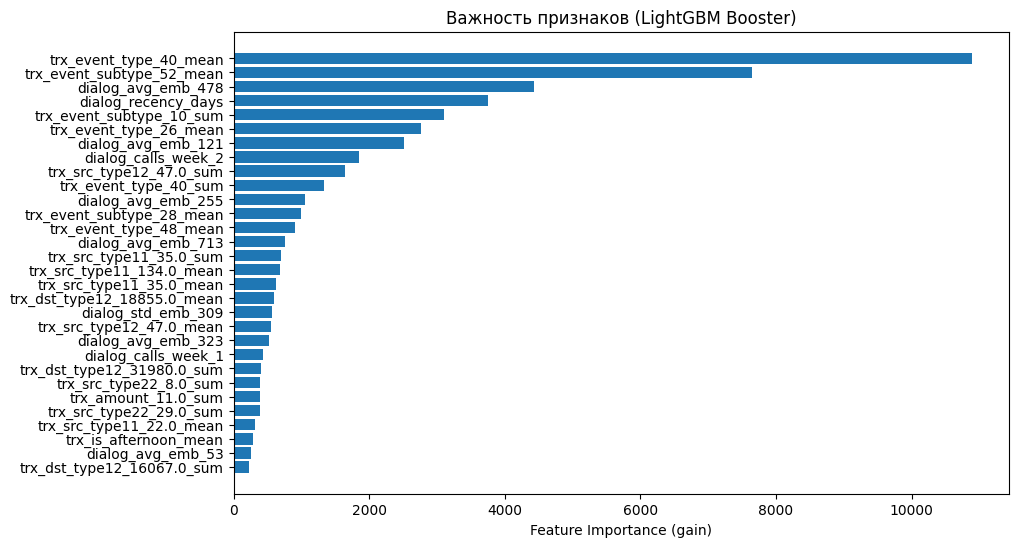

In [76]:
# Если X_train — DataFrame с именами признаков:
features = X_train.columns
importances = model.feature_importance(importance_type='gain')  # можно выбрать 'split' или 'gain'

# Создадим DataFrame для визуализации
importance_df = pd.DataFrame({'feature': features, 'importance': importances})
importance_df = importance_df.sort_values(by='importance', ascending=False)

# Выбираем топ 20 признаков
top_n = 30
top_features = importance_df.head(top_n)

# Построим график важности признаков
plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['importance'])
plt.gca().invert_yaxis()  # самые важные признаки наверху
plt.xlabel("Feature Importance (gain)")
plt.title("Важность признаков (LightGBM Booster)")
plt.show()


In [51]:
params = {
    'objective': 'binary',          # Задача бинарной классификации
    'metric': 'auc',                # Метрика для оценки – AUC
    'boosting_type': 'gbdt',        # Классический градиентный бустинг
    'num_leaves': 24,               # Максимальное число листьев (оптимальное значение зависит от данных)
    'max_depth': 5,                 # Ограничение глубины деревьев для предотвращения переобучения
    'learning_rate': 0.01,          # Скорость обучения
    'reg_alpha': 0.5,               # L1 регуляризация (Lasso) – штраф на абсолютные значения коэффициентов
    'reg_lambda': 0.5,              # L2 регуляризация (Ridge) – штраф на квадраты коэффициентов
    'min_split_gain': 0.01,         # Минимальное улучшение, необходимое для разделения узла
    'min_child_samples': 20,        # Минимальное число объектов в листе
    'subsample': 0.8,               # Доля выборки для каждой итерации (bagging)
    'colsample_bytree': 0.8,        # Доля признаков для каждого дерева
    'seed': 42
}

model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,
    valid_sets=[train_data, valid_data],  
    callbacks=[
        lgb.log_evaluation(period=10),
        lgb.early_stopping(stopping_rounds=20),
    ]
)

Training until validation scores don't improve for 20 rounds
[10]	training's auc: 0.827242	valid_1's auc: 0.701712
[20]	training's auc: 0.840328	valid_1's auc: 0.716229
[30]	training's auc: 0.843809	valid_1's auc: 0.719248
[40]	training's auc: 0.846986	valid_1's auc: 0.720947
[50]	training's auc: 0.856243	valid_1's auc: 0.724055
[60]	training's auc: 0.86159	valid_1's auc: 0.725536
[70]	training's auc: 0.864694	valid_1's auc: 0.72642
[80]	training's auc: 0.868061	valid_1's auc: 0.727161
[90]	training's auc: 0.87156	valid_1's auc: 0.727952
[100]	training's auc: 0.879201	valid_1's auc: 0.733917
[110]	training's auc: 0.882296	valid_1's auc: 0.733571
[120]	training's auc: 0.88438	valid_1's auc: 0.732602
Early stopping, best iteration is:
[101]	training's auc: 0.879239	valid_1's auc: 0.733955


In [148]:
df.shape

(925679, 2273)

In [149]:
df_targets.shape

(1202688, 8)

In [150]:
df_merged.shape

(925679, 2267)

In [140]:
df_targets['mon'].unique()

array(['2022-02-28', '2022-03-31', '2022-04-30', '2022-05-31',
       '2022-06-30', '2022-07-31', '2022-08-31', '2022-09-30',
       '2022-10-31', '2022-11-30', '2022-12-31', '2023-01-31'],
      dtype=object)

In [141]:
df_merged.columns

Index(['client_id', 'mon', 'trx_trx_dummy_sum', 'trx_is_rare_event_type_sum',
       'trx_is_rare_event_type_mean', 'trx_is_rare_event_subtype_sum',
       'trx_is_rare_event_subtype_mean', 'trx_is_huge_transfer_sum',
       'trx_is_huge_transfer_mean', 'trx_match_src_type11_dst_type11_sum',
       ...
       'dialog_std_emb_758', 'dialog_std_emb_759', 'dialog_std_emb_760',
       'dialog_std_emb_761', 'dialog_std_emb_762', 'dialog_std_emb_763',
       'dialog_std_emb_764', 'dialog_std_emb_765', 'dialog_std_emb_766',
       'dialog_std_emb_767'],
      dtype='object', length=2267)

In [143]:
df_merged['mon'].unique()

<DatetimeArray>
['2022-02-28 00:00:00', '2022-03-31 00:00:00', '2022-04-30 00:00:00',
 '2022-05-31 00:00:00', '2022-06-30 00:00:00', '2022-07-31 00:00:00',
 '2022-08-31 00:00:00', '2022-09-30 00:00:00', '2022-10-31 00:00:00',
 '2022-11-30 00:00:00', '2022-12-31 00:00:00', '2023-01-31 00:00:00']
Length: 12, dtype: datetime64[ns]

In [76]:
df_agg_trx[df_agg_trx['amount_-1.0_mean'].isna()]

,client_id,mon,trx_dummy_sum,event_time_max,month_end_first,is_rare_event_type_sum,is_rare_event_type_mean,is_rare_event_subtype_sum,is_rare_event_subtype_mean,is_huge_transfer_sum,...,currency_15.0_mean,currency_16.0_sum,currency_16.0_mean,currency_17.0_sum,currency_17.0_mean,is_morning_mean,is_afternoon_mean,is_evening_mean,is_night_mean,recency_days
12,00005e39da5fb5968996cd49130281c8bd074a42e0e17a...,2022-01-01,0,NaT,NaT,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
13,00005e39da5fb5968996cd49130281c8bd074a42e0e17a...,2022-02-01,0,NaT,NaT,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
14,00005e39da5fb5968996cd49130281c8bd074a42e0e17a...,2022-03-01,0,NaT,NaT,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
15,00005e39da5fb5968996cd49130281c8bd074a42e0e17a...,2022-04-01,0,NaT,NaT,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
16,00005e39da5fb5968996cd49130281c8bd074a42e0e17a...,2022-05-01,0,NaT,NaT,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1174530,fffebdea9b005f6c35c1ffdce054ca9363a8ed267fbaa4...,2022-07-01,0,NaT,NaT,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1174541,fffec89a82f07dc592f7e783e068ef329011809621d09f...,2022-06-01,0,NaT,NaT,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1174542,fffec89a82f07dc592f7e783e068ef329011809621d09f...,2022-07-01,0,NaT,NaT,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN
1174543,fffec89a82f07dc592f7e783e068ef329011809621d09f...,2022-08-01,0,NaT,NaT,0,NaN,0,NaN,0,...,NaN,0,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
amount_cols

,amount_1.0,amount_3.0,amount_4.0,amount_5.0,amount_6.0,amount_8.0,amount_9.0,amount_10.0,amount_11.0,amount_12.0,amount_15.0,amount_16.0,amount_17.0
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.766723e+03,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.253846e+03,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.131974e+03,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.204814e+02,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.333538e+02,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
38764925,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.149164e+06,0.0,0.0,0.0,0.0
38764926,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.215694e+03,0.0,0.0,0.0,0.0
38764927,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.814023e+04,0.0,0.0,0.0,0.0
38764928,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.264204e+04,0.0,0.0,0.0,0.0


In [10]:
df_trx['currency'].unique().shape

(14,)

In [1]:
1

1

In [57]:
df_trx['src_type11_clean'].value_counts()

src_type11_clean
 22.0     28639510
 35.0      4731815
 134.0     1414795
 141.0      980947
 175.0      808927
 102.0      710017
 4.0        323357
 105.0      265665
-1.0        236323
 111.0      116271
 97.0       113361
 60.0        79503
 74.0        65608
 85.0        54638
 124.0       49467
 139.0       46178
 158.0       32161
 120.0       31678
 92.0        26474
 65.0        10426
 10.0         9342
 54.0         9069
 132.0        4734
 172.0        4664
Name: count, dtype: int64

In [43]:
df_part = df_trx.loc[:1000]


# Предполагаем, что DataFrame с транзакциями называется df_trx
# и содержит столбцы: client_id, event_time, amount, fold, event_type, event_subtype, 
# currency, src_type11, src_type12, dst_type11, dst_type12, src_type21, src_type22, src_type31, src_type32

# 1. Приводим event_time к типу datetime и создаём столбец 'mon' – первый день месяца
df_part['event_time'] = pd.to_datetime(df_part['event_time'])
df_part['mon'] = df_part['event_time'].dt.to_period('M').dt.to_timestamp()

# 2. Определяем словарь агрегаций
# Для числовых переменных (например, amount) считаем количество транзакций, сумму, среднее, медиану и стандартное отклонение
# Для категориальных переменных (например, event_type, event_subtype, currency, и прочих) можно посчитать число уникальных значений
agg_dict = {
    'amount': ['count', 'sum', 'mean', 'median', 'std'],  # count = общее число транзакций (также можно назвать его trx_count)
    'event_type': lambda x: x.nunique(),
    'event_subtype': lambda x: x.nunique(),
    'currency': lambda x: x.nunique(),
    'src_type11': lambda x: x.nunique(),
    'src_type12': lambda x: x.nunique(),
    'dst_type11': lambda x: x.nunique(),
    'dst_type12': lambda x: x.nunique(),
    'src_type21': lambda x: x.nunique(),
    'src_type22': lambda x: x.nunique(),
    'src_type31': lambda x: x.nunique(),
    'src_type32': lambda x: x.nunique()
}

# 3. Группируем данные по client_id и mon и применяем агрегацию
df_agg = df_part.groupby(['client_id', 'mon']).agg(agg_dict)

# 4. Если агрегирование создало MultiIndex для столбцов, его можно "развернуть"
df_agg.columns = ['_'.join([str(c) for c in col]).strip() for col in df_agg.columns.values]
df_agg.reset_index(inplace=True)

# Посмотрим на результат:



/tmp/ipykernel_839288/4048681565.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part['event_time'] = pd.to_datetime(df_part['event_time'])
/tmp/ipykernel_839288/4048681565.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part['mon'] = df_part['event_time'].dt.to_period('M').dt.to_timestamp()


In [46]:
import pandas as pd

# Предположим, что DataFrame с транзакциями называется df_trx
# и содержит столбцы 'client_id', 'event_time', 'src_type11', и т.д.
df_part = df_trx.loc[:1000]

# 1. Приводим event_time к типу datetime, если ещё не сделано:
df_part['event_time'] = pd.to_datetime(df_part['event_time'])

# 2. Создаём столбец "mon" — первый день месяца, к которому относится транзакция:
df_part['mon'] = df_part['event_time'].dt.to_period('M').dt.to_timestamp()

# 3. Группируем по клиенту, месяцу и значению src_type11, считаем количество транзакций:
agg = df_part.groupby(['client_id', 'mon', 'src_type11']).size().reset_index(name='trx_count')

# 4. Преобразуем агрегированные данные в сводную таблицу, где:
#    - строки: client_id, mon
#    - столбцы: разные значения src_type11
#    - значения: количество транзакций (если транзакций нет — заполняем нулями)
pivot_df = agg.pivot_table(index=['client_id', 'mon'], 
                           columns='src_type11', 
                           values='trx_count', 
                           fill_value=0).reset_index()

# Для наглядности можно добавить префикс к названиям столбцов, соответствующих src_type11
pivot_df = pivot_df.rename(columns=lambda x: f'src_type11_count_{x}' if x not in ['client_id', 'mon'] else x)

# Выведем результат:
print(pivot_df.head())


src_type11                                          client_id        mon  \
0           1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f... 2021-01-01   
1           1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f... 2021-02-01   
2           1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f... 2021-03-01   
3           1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f... 2021-04-01   
4           1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f... 2021-05-01   

src_type11  src_type11_count_22.0  src_type11_count_35.0  
0                             8.0                   28.0  
1                             0.0                   44.0  
2                             0.0                   45.0  
3                             0.0                   37.0  
4                             0.0                   45.0  


/tmp/ipykernel_839288/879061591.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part['event_time'] = pd.to_datetime(df_part['event_time'])
/tmp/ipykernel_839288/879061591.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_part['mon'] = df_part['event_time'].dt.to_period('M').dt.to_timestamp()


In [48]:
pivot_df

src_type11,client_id,mon,src_type11_count_22.0,src_type11_count_35.0
0,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-01-01,8.0,28.0
1,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-02-01,0.0,44.0
2,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-03-01,0.0,45.0
3,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-04-01,0.0,37.0
4,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-05-01,0.0,45.0
5,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-06-01,0.0,33.0
6,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-07-01,0.0,31.0
7,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-08-01,0.0,18.0
8,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-09-01,0.0,37.0
9,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-10-01,0.0,52.0


In [53]:
df_part['src_type11'].unique()

array([22., 35.])

In [34]:
import pandas as pd

# Функция для вычисления порога выбросов по IQR для заданного столбца
def compute_outlier_threshold(df, column='amount', factor=1.5):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return Q3 + factor * IQR

# Предполагаем, что DataFrame с транзакциями называется df_trx 
# и содержит столбцы 'currency' и 'ammount'

# Изначально создаём столбец с нулями (0 - не выброс, 1 - выброс)
df_trx['is_outlier'] = 0

# Для каждой валюты вычисляем порог и помечаем выбросы
for currency in df_trx['currency'].unique():
    curr_df = df_trx[df_trx['currency'] == currency]
    threshold = compute_outlier_threshold(curr_df, column='amount', factor=1.5)
    print(f"Валюта {currency}: порог выбросов = {threshold:.2f}")
    
    # Обновляем DataFrame: для транзакций с суммой больше порога ставим 1
    df_trx.loc[(df_trx['currency'] == currency) & (df_trx['amount'] > threshold), 'is_outlier'] = 1

# Посмотрим на распределение выбросов по валютам:
print(df_trx.groupby('currency')['is_outlier'].mean())


Валюта 11.0: порог выбросов = 232726.99
Валюта 3.0: порог выбросов = 7325330.44
Валюта 15.0: порог выбросов = 13217135.27
Валюта 6.0: порог выбросов = 32242501.10
Валюта 4.0: порог выбросов = 5396561.34
Валюта 10.0: порог выбросов = 3463201.08
Валюта 1.0: порог выбросов = 581374.25
Валюта 17.0: порог выбросов = 731018.21
Валюта 9.0: порог выбросов = 2686606.63
Валюта nan: порог выбросов = nan
Валюта 16.0: порог выбросов = 27919.19
Валюта 8.0: порог выбросов = 121353.43
Валюта 12.0: порог выбросов = 112854833.69
Валюта 5.0: порог выбросов = 59846694.47
currency
1.0     0.213836
3.0     0.142344
4.0     0.166880
5.0     0.000000
6.0     0.121951
8.0     0.178161
9.0     0.000000
10.0    0.155779
11.0    0.142582
12.0    0.250000
15.0    0.142572
16.0    0.142857
17.0    0.188341
Name: is_outlier, dtype: float64


In [35]:
df_trx[df_trx['is_outlier'] == 1]

,client_id,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32,is_outlier
10,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-03-24 03:29:41.340756,3.860292e+05,1,12,11.0,35.0,804.0,780.0,14702.0,9477.0,7.0,1846.0,60.0,1
26,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-12-12 08:55:31.680358,2.090588e+06,1,12,11.0,35.0,804.0,306.0,26766.0,9477.0,7.0,1846.0,60.0,1
31,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-06-08 07:08:53.661283,2.479618e+06,1,12,11.0,35.0,804.0,306.0,26766.0,9477.0,7.0,1846.0,60.0,1
47,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-03-03 08:02:50.347590,1.222421e+06,1,12,11.0,35.0,804.0,306.0,26766.0,9477.0,7.0,1846.0,60.0,1
52,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2022-07-10 11:12:12.219741,2.557242e+06,1,12,11.0,35.0,804.0,306.0,26766.0,9477.0,7.0,1846.0,60.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38764904,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-10-11 15:48:21.049670,2.488788e+05,48,6,11.0,22.0,47.0,793.0,24565.0,29004.0,46.0,2248.0,26.0,1
38764911,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-09-11 12:24:12.221727,4.825156e+05,48,10,11.0,22.0,47.0,90.0,15311.0,29004.0,46.0,2248.0,26.0,1
38764913,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-12-02 23:55:40.587283,9.640834e+05,48,6,11.0,22.0,47.0,793.0,24565.0,29004.0,46.0,2248.0,26.0,1
38764918,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-11-21 22:58:51.401137,8.926519e+05,48,6,11.0,22.0,47.0,793.0,24565.0,29004.0,46.0,2248.0,26.0,1


In [25]:
df_trx.event_time.min()

Timestamp('2020-12-31 21:00:02.169545')

In [26]:
df_trx.event_time.max()

Timestamp('2022-12-31 20:59:58.460193')

In [32]:
df_trx

,client_id,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32
0,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-01-10 10:25:54.577961,5.766723e+03,11,12,11.0,22.0,139.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
1,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-06-21 10:05:24.821002,1.253846e+03,38,16,11.0,35.0,804.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
2,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-07-05 07:28:21.303191,1.131974e+03,38,16,11.0,35.0,804.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
3,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-06-20 10:17:20.436292,3.204814e+02,38,16,11.0,35.0,804.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
4,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-06-10 03:37:07.429880,2.333538e+02,38,16,11.0,35.0,804.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38764925,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-08-10 13:14:11.427807,1.149164e+06,48,10,11.0,22.0,47.0,90.0,15311.0,29004.0,46.0,2248.0,26.0
38764926,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-08-30 03:02:21.644615,4.215694e+03,48,10,11.0,NaN,NaN,NaN,NaN,29004.0,46.0,2248.0,26.0
38764927,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-09-23 13:13:41.643101,2.814023e+04,43,47,11.0,22.0,47.0,1569.0,7793.0,29004.0,46.0,2248.0,26.0
38764928,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-12-21 09:37:36.837476,2.264204e+04,43,47,11.0,22.0,47.0,1569.0,7793.0,29004.0,46.0,2248.0,26.0


In [31]:
df_targets.mon.max(), df_targets.mon.min()

('2023-01-31', '2022-02-28')

In [11]:
df_trx['currency'].value_counts()

currency
11.0    38724240
3.0        20324
15.0       16041
4.0         3128
17.0         446
10.0         199
8.0          174
1.0          159
6.0           82
16.0           7
5.0            6
12.0           4
9.0            2
Name: count, dtype: int64

In [12]:
df_trx

,client_id,event_time,amount,event_type,event_subtype,currency,src_type11,src_type12,dst_type11,dst_type12,src_type21,src_type22,src_type31,src_type32
0,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-01-10 10:25:54.577961,5.766723e+03,11,12,11.0,22.0,139.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
1,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-06-21 10:05:24.821002,1.253846e+03,38,16,11.0,35.0,804.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
2,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-07-05 07:28:21.303191,1.131974e+03,38,16,11.0,35.0,804.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
3,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-06-20 10:17:20.436292,3.204814e+02,38,16,11.0,35.0,804.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
4,1128635c2921edc8b6ed3c6d9178bd055d2d421a0f155f...,2021-06-10 03:37:07.429880,2.333538e+02,38,16,11.0,35.0,804.0,780.0,21619.0,9477.0,7.0,1846.0,60.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38764925,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-08-10 13:14:11.427807,1.149164e+06,48,10,11.0,22.0,47.0,90.0,15311.0,29004.0,46.0,2248.0,26.0
38764926,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-08-30 03:02:21.644615,4.215694e+03,48,10,11.0,NaN,NaN,NaN,NaN,29004.0,46.0,2248.0,26.0
38764927,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-09-23 13:13:41.643101,2.814023e+04,43,47,11.0,22.0,47.0,1569.0,7793.0,29004.0,46.0,2248.0,26.0
38764928,f71019f44e81b589cc362a7d7ee1140b8146e374279657...,2022-12-21 09:37:36.837476,2.264204e+04,43,47,11.0,22.0,47.0,1569.0,7793.0,29004.0,46.0,2248.0,26.0


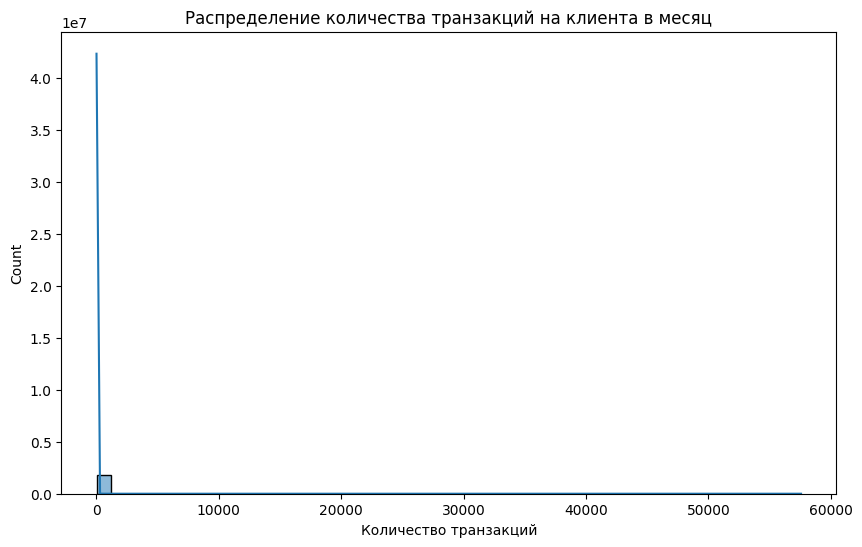

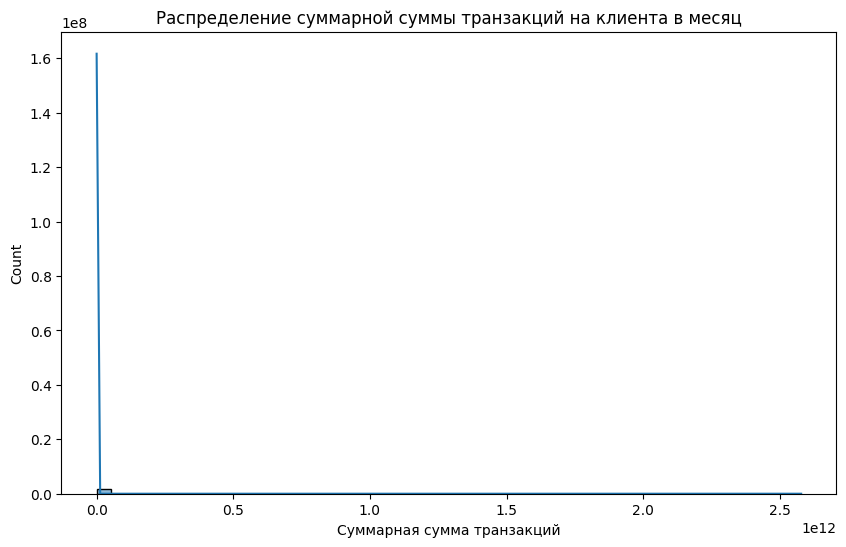

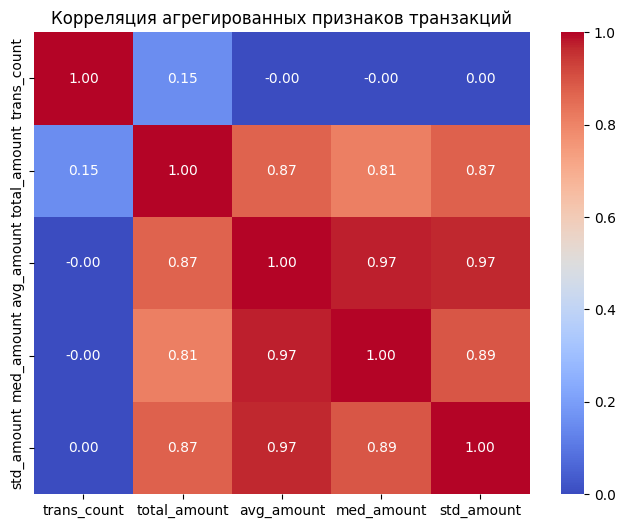

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Приведение event_time к datetime, если еще не сделано
df_trx['event_time'] = pd.to_datetime(df_trx['event_time'])

# Создадим столбец mon – первый день месяца
df_trx['mon'] = df_trx['event_time'].dt.to_period('M').dt.to_timestamp()

# Агрегируем на уровне клиента и месяца:
client_monthly = df_trx.groupby(['client_id', 'mon']).agg(
    trans_count=('amount', 'count'),
    total_amount=('amount', 'sum'),
    avg_amount=('amount', 'mean'),
    med_amount=('amount', 'median'),
    std_amount=('amount', 'std'),
    min_amount=('amount', 'min'),
    max_amount=('amount', 'max')
).reset_index()

# Посмотрим на распределения:
plt.figure(figsize=(10, 6))
sns.histplot(client_monthly['trans_count'], bins=50, kde=True)
plt.title("Распределение количества транзакций на клиента в месяц")
plt.xlabel("Количество транзакций")
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(client_monthly['total_amount'], bins=50, kde=True)
plt.title("Распределение суммарной суммы транзакций на клиента в месяц")
plt.xlabel("Суммарная сумма транзакций")
plt.show()

# Корреляционная матрица агрегированных признаков:
corr_matrix = client_monthly[['trans_count', 'total_amount', 'avg_amount', 'med_amount', 'std_amount']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Корреляция агрегированных признаков транзакций")
plt.show()
